In [1]:
import numpy as np
from qiskit import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
import random
import math
from qiskit.tools.monitor import job_monitor
%matplotlib inline

In [15]:
# Choose a real device to simulate
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()

ibmqfactory.load_account:WARNING:2020-06-16 13:55:51,509: Credentials are already in use. The existing account in the session will be replaced.


In [16]:
import numpy as np

backend_defaults = backend.defaults()
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

Sampling time: 0.2222222222222222 ns
Qubit 0 has an estimated frequency of 4.974445794773773 GHz.


In [17]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes

In [18]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit)

In [60]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [206]:
# Rabi experiment parameters
num_amplitudes = 1
num_rabi_points = 50

# Drive amplitude values to iterate over: amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

rabi_schedules = []
pulse_info = []

for i in range(num_amplitudes):
    # Drive pulse parameters (us = microseconds)
    drive_sigma_us = 10 + (i * 0.01)        # This determines the actual width of the gaussian
    drive_samples_us = 0.07*8        # This is a truncating parameter, because gaussians don't have 
                                               # a natural finite length

    drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
    drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

    pulse_info.append([drive_sigma, drive_samples])
    
    for drive_amp in drive_amps:
        rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                        sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
        this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
        this_schedule += Play(rabi_pulse, drive_chan)
        # Reuse the measure instruction from the frequency sweep experiment
        this_schedule += measure << this_schedule.duration
        rabi_schedules.append(this_schedule)

In [207]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: backend_defaults.qubit_freq_est[qubit]}]
                                                * num_rabi_points * num_amplitudes)
job = backend.run(rabi_experiment_program)
print(job.job_id())
job_monitor(job)

5ee9a5ab28b087001ab2a2af
Job Status: job has successfully run


In [208]:
rabi_results = job.result(timeout=120)

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)
rabi_values = []

for i in range(num_amplitudes):
    amp_values = []
    for j in range(num_rabi_points):
        # Get the results for `qubit` from the ith experiment
        amp_values.append(rabi_results.get_memory(num_amplitudes*i + j)[qubit]*scale_factor)
    rabi_values.append(amp_values)
        
rabi_values = [np.real(baseline_remove(x)) for x in rabi_values]

In [211]:
rabi_fit_params = []
y_fits = []

for val in rabi_values:
    fit_params, y_fit = fit_function(drive_amps,
                                     val, 
                                     lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                     [6, 0.1, 0.2, 0])
    rabi_fit_params.append(fit_params)
    y_fits.append(y_fit)

#     drive_period = fit_params[2] 
#     pi_amp = abs(drive_period / 2)

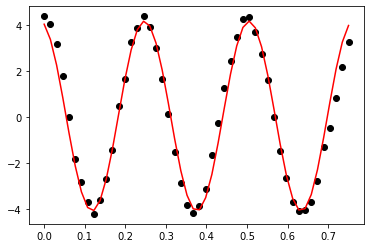

In [212]:
amp = 0
plt.scatter(drive_amps, rabi_values[amp], color='black')
plt.plot(drive_amps, y_fits[amp], color='red')

In [213]:
for i in range(num_amplitudes):
    pi_amp = abs(rabi_fit_params[i][2] / 2)
    pulse_info[i].append(pi_amp)
    print(f"Pi Amplitude = {abs(rabi_fit_params[i][2] / 2)}")
    print(f"Duration = {pulse_info[i][1]}")
    print(f"Sigma = {pulse_info[i][0]}")
    print()

Pi Amplitude = 0.1288427939696463
Duration = 2528
Sigma = 45008



In [201]:
pulse_info

[[96, 720, 0.8358788848870128]]

In [202]:
num_rabi_points = 50

# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

rabi_schedules = []
durations = []
for i in range(len(pulse_info)):
    drive_samples = pulse_info[i][1]
    for j in range(num_rabi_points):
        duration = get_closest_multiple_of_16(drive_samples+(j*16))
        rabi_pulse = pulse_lib.GaussianSquare(duration=duration, 
                                        amp=pulse_info[i][2], 
                                        sigma=pulse_info[i][0],
                                        width=j*16,
                                        name=f"Rabi duration = {duration}")

        this_schedule = pulse.Schedule(name=f"Rabi duration = {duration}")
        this_schedule += Play(rabi_pulse, drive_chan)
        # Reuse the measure instruction from the frequency sweep experiment
        this_schedule += measure << this_schedule.duration
        rabi_schedules.append(this_schedule)
        durations.append(duration)

In [203]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: backend_defaults.qubit_freq_est[qubit]}]
                                                * num_rabi_points)
job = backend.run(rabi_experiment_program)
print(job.job_id())
job_monitor(job)

5ee9a39b3fe92c001a26ca45
Job Status: job has successfully run


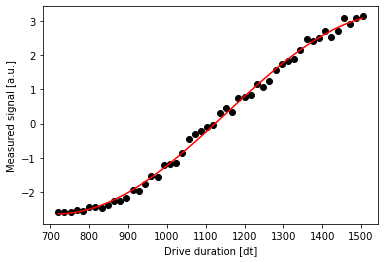

Period for amplitude = 0.8358788848870128, 1747.5439148745565


In [205]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)
rabi_values = np.real(baseline_remove(rabi_values))

fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)
fit_params, conv = curve_fit(fit_func, durations, rabi_values, [8,0,800,0])
y_fit = [fit_func(x, fit_params[0], fit_params[1], fit_params[2], fit_params[3]) for x in durations]

plt.xlabel("Drive duration [dt]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(durations, rabi_values, color='black') # plot real part of Rabi values
plt.plot(durations, y_fit, color='red')
plt.show()
print(f'Period for amplitude = {pulse_info[0][2]}, {fit_params[2]}')